# Setup

In [113]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

!pip install -U scikit-learn

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from matplotlib.colors import ListedColormap




#Part 1: Decision Trees

**Importing dataset**

In [99]:
import pandas as pd
data = pd.read_csv('preprocessed.csv')


## Training and visualizing

**Step 1: Categorizing Coffee Quality Based on Total Cup Points & Selecting Relevant Features**

In [103]:
if 'Total Cup Points' in data.columns:
    
    data['Total Cup Points/60'] = data['Total Cup Points'] / 60   #Normalize 'Total Cup Points' by dividing by 60 
    low_threshold = data['Total Cup Points/60'].quantile(0.33)
    high_threshold = data['Total Cup Points/60'].quantile(0.66)

    
    def categorize_quality(score):
        if score <= low_threshold:
            return 'Low Quality'
        elif score <= high_threshold:                     # Defining the quality categories based on percentiles
            return 'Moderate Quality'
        else:
            return 'High Quality'

    
    data['Quality Category'] = data['Total Cup Points/60'].apply(categorize_quality)  # Applying the categorization function to create a new column

    print(data['Quality Category'].value_counts())
else:
    print("Column 'Total Cup Points' not found in the dataframe.")


X = data[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall']].values  # Select relevant features
y = data['Quality Category'].values

Quality Category
Moderate Quality    71
High Quality        68
Low Quality         68
Name: count, dtype: int64


**Scaling and Applying PCA to the Data**

In [106]:
scaler = StandardScaler()                                # Scaling the data
data_scaled = scaler.fit_transform(X) 


pca = PCA(n_components=2)                              # Applying PCA to reduce to 2D
data_pca = pca.fit_transform(data_scaled) 


class_mapping = {'Low Quality': 0, 'Moderate Quality': 1, 'High Quality': 2}
y = np.array([class_mapping[label] for label in y], dtype=np.int64)

**Building a Decision Tree Classifier on PCA-Reduced Coffee Quality Data (Original -Depth 2)**

In [108]:
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(data_pca, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

**Plotting the decision tree classifier**

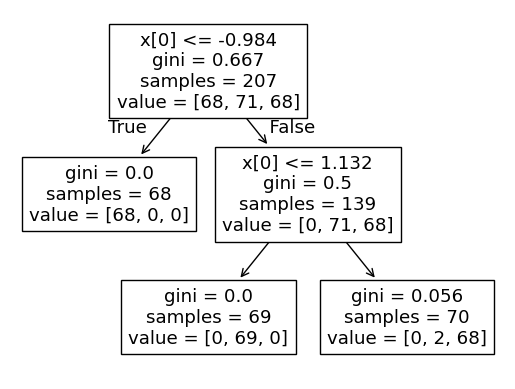

In [81]:
plot_tree(tree_clf_pca);

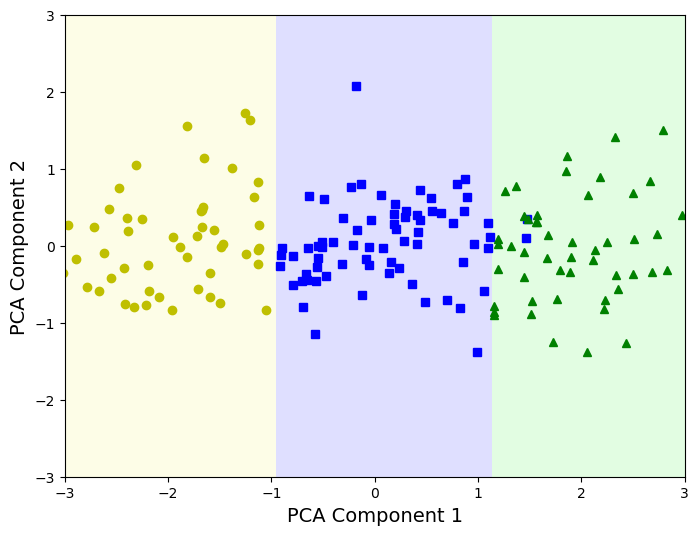

In [75]:
def plot_decision_boundary(clf, X, y, axes=[-3, 3, -3, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Low Quality")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Moderate Quality")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], "g^", label="High Quality")
        plt.axis(axes)

    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    if legend:
        plt.legend(loc="lower right", fontsize=14)


plt.figure(figsize=(8, 6))
plot_decision_boundary(tree_clf_pca, data_pca, y)     # Plot decision boundary
plt.show()


## Predicting classes and class probabilities

In [36]:
tree_clf_pca.predict_proba([[-2,0.9 ]])

array([[1., 0., 0.]])

In [37]:
tree_clf_pca.predict([[-2,0.9 ]])

array([0])

## Sensitivity to training set details

More generally, the main issue with Decision Trees is that they are very sensitive to small variations in the training data. For example, if you just remove the widest Iris versicolor from the iris training set (the one with petals 4.8 cm long and 1.8 cm wide) and train a new Decision Tree, you may get the model represented as follows


In [44]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)]

array([[ 0.37966361,  0.91513891, -0.36243735,  0.23064564,  0.46829486,
         0.41435502,  0.50124135]])

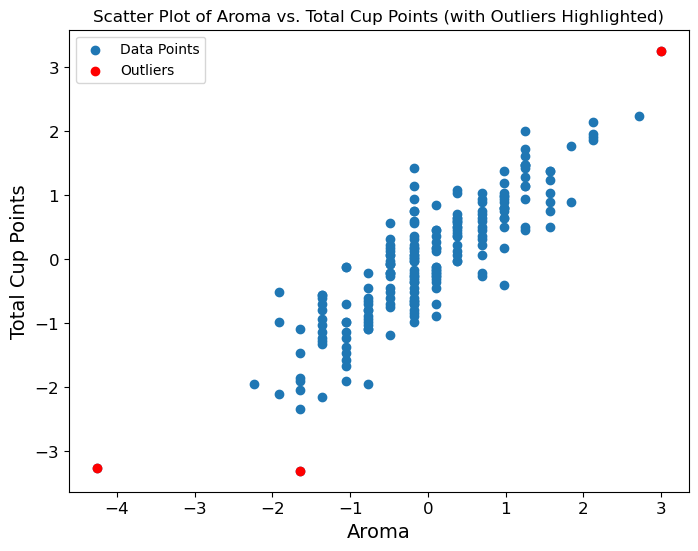

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('preprocessed.csv')  # Make sure the path is correct

# Convert 'Total Cup Points' to numeric if needed
data['Total Cup Points'] = pd.to_numeric(data['Total Cup Points'], errors='coerce')

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['Total Cup Points'].quantile(0.25)
Q3 = data['Total Cup Points'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['Total Cup Points'] < lower_bound) | (data['Total Cup Points'] > upper_bound)]



# Scatter plot to visualize outliers in relation to another feature (e.g., Aroma)
plt.figure(figsize=(8, 6))
plt.scatter(data['Aroma'], data['Total Cup Points'], label='Data Points')
plt.scatter(outliers['Aroma'], outliers['Total Cup Points'], color='red', label='Outliers')
plt.title("Scatter Plot of Aroma vs. Total Cup Points (with Outliers Highlighted)")
plt.xlabel("Aroma")
plt.ylabel("Total Cup Points")
plt.legend()
plt.show()


In [5]:
# Identify outliers (as before)
outliers = data[(data['Total Cup Points'] < lower_bound) | (data['Total Cup Points'] > upper_bound)]

# To get the maximum outlier value
max_outlier_value = data['Total Cup Points'][data['Total Cup Points'] > upper_bound].max()

# Filter the dataset to find rows where 'Total Cup Points' is equal to the maximum outlier value
max_outliers = data[(data['Total Cup Points'] == max_outlier_value) & (data['Total Cup Points'] > upper_bound)]

# Display the maximum outlier rows
print(max_outliers)


   ID Country of Origin Processing Method     Aroma    Flavor  Aftertaste  \
0   0          Colombia             Other  2.993534  2.707661     2.98006   

    Acidity      Body   Balance   Overall         Color  \
0  3.436732  2.614819  3.034825  2.955285  Multicolored   

                     Altitude  Total Cup Points Continent of Origin  
0  High Altitude (1600-2000m)          3.257632             America  


In [7]:
# Assuming 'outliers' have already been identified as before
# Create a boolean mask to select non-outlier data
not_outliers = ~((data['Total Cup Points'] < lower_bound) | (data['Total Cup Points'] > upper_bound))

# Apply the mask to your dataset to exclude outliers
data_no_outliers = data[not_outliers]

# Alternatively, you can directly modify your original dataframe
data = data[not_outliers]

# Now, 'data_no_outliers' contains your dataset without the identified outliers
print(data_no_outliers)


      ID Country of Origin Processing Method     Aroma    Flavor  Aftertaste  \
1      1            Taiwan      Washed / Wet  2.714721  2.707661    1.163485   
2      2              Laos             Other  2.122244  2.420858    1.744789   
3      3        Costa Rica      Washed / Wet  1.250954  1.524596    2.071773   
4      4          Colombia             Other  2.122244  2.098204    1.744789   
5      5         Guatemala      Washed / Wet  2.122244  2.098204    2.362425   
..   ...               ...               ...       ...       ...         ...   
200  200       El Salvador     Natural / Dry -2.234207 -1.773645   -1.888360   
201  201            Brazil     Natural / Dry -1.641729 -2.060448   -1.561377   
202  202            Brazil     Natural / Dry -1.920542 -2.060448   -2.469664   
203  203         Nicaragua     Natural / Dry -1.362917 -2.383102   -3.087299   
204  204              Laos      Washed / Wet -1.641729 -2.060448   -1.888360   

      Acidity      Body   Balance   Ove

In [26]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale the tweaked data
scaler = StandardScaler()
X_tweaked_scaled = scaler.fit_transform(X_tweaked)

# Apply PCA to reduce tweaked data to 2D
pca = PCA(n_components=2)
X_tweaked_pca = pca.fit_transform(X_tweaked_scaled)

from sklearn.tree import DecisionTreeClassifier

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_tweaked.fit(X_tweaked_pca, y_tweaked)


NameError: name 'X' is not defined

[Text(0.4, 0.8333333333333334, 'x[0] <= -0.984\ngini = 0.667\nsamples = 207\nvalue = [68, 71, 68]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 68\nvalue = [68, 0, 0]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[0] <= 1.132\ngini = 0.5\nsamples = 139\nvalue = [0, 71, 68]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 69\nvalue = [0, 69, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.056\nsamples = 70\nvalue = [0, 2, 68]')]

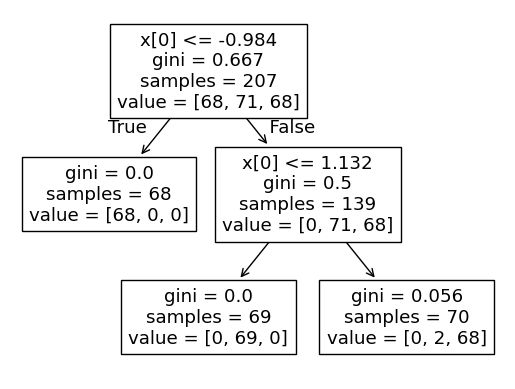

In [40]:
plot_tree(tree_clf_tweaked)



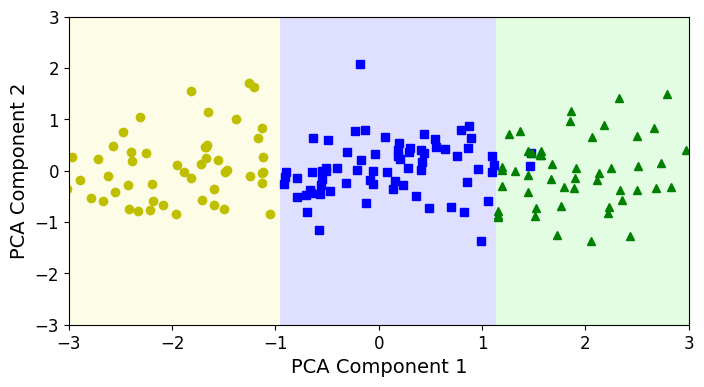

In [43]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked_pca, y_tweaked)
#plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
#plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
#plt.text(1.0, 0.9, "Depth=0", fontsize=15)
#plt.text(1.0, 1.80, "Depth=1", fontsize=13)
plt.show()

## Regularization Hyperparameters

To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training. As you know by now, this is called regularization.
Regularization hyperparameters for example can restrict the maximum depth of the Decision Tree.
This is controlled by the max_depth hyperparameter (the default value is None, which means unlimited). Reducing max_depth will regularize the model and thus reduce the risk of overfitting.



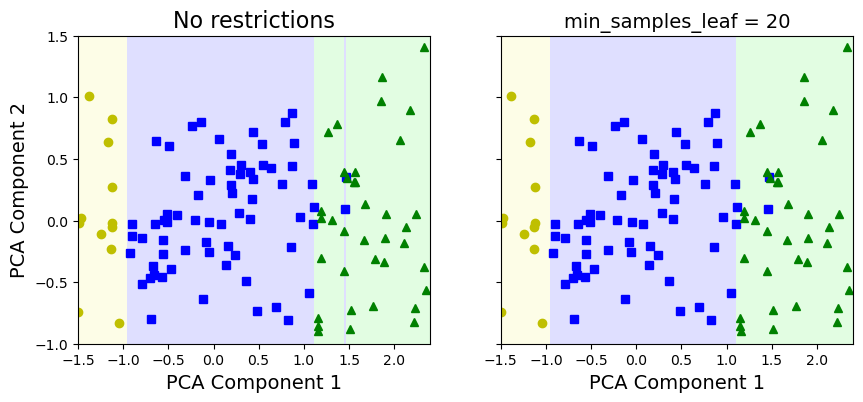

In [39]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tree_clf_no_reg = DecisionTreeClassifier(random_state=42)
tree_clf_reg = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
tree_clf_no_reg.fit(X_pca, y)
tree_clf_reg.fit(X_pca, y)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# Plot the decision boundary for the tree with no regularization
plt.sca(axes[0])
plot_decision_boundary(tree_clf_no_reg, X_pca, y, axes=[-1.5, 2.4, -1, 1.5])
plt.title("No restrictions", fontsize=16)

# Plot the decision boundary for the tree with min_samples_leaf regularization
plt.sca(axes[1])
plot_decision_boundary(tree_clf_reg, X_pca, y, axes=[-1.5, 2.4, -1, 1.5])
plt.title("min_samples_leaf = {}".format(tree_clf_reg.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()



## Instability
Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation.

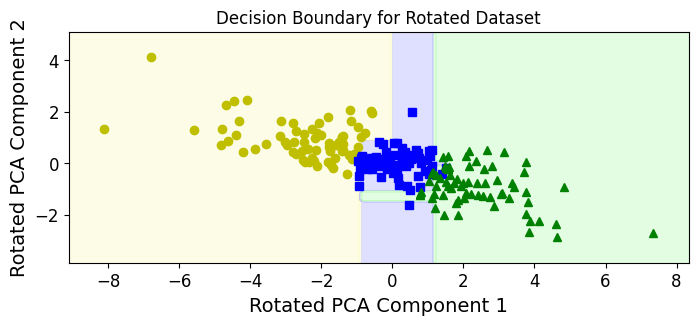

In [58]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Step 2: Define the rotation matrix for a 20-degree rotation
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

# Step 3: Rotate the 2D data
X_rotated = X_2d.dot(rotation_matrix)

# Step 4: Train a Decision Tree Classifier on the rotated dataset
tree_clf_rotated = DecisionTreeClassifier(random_state=42)
tree_clf_rotated.fit(X_rotated, y)

# Step 5: Plot the decision boundary
plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_rotated, X_rotated, y, axes=[X_rotated[:, 0].min() - 1, X_rotated[:, 0].max() + 1,
                                                            X_rotated[:, 1].min() - 1, X_rotated[:, 1].max() + 1])
plt.xlabel("Rotated PCA Component 1")
plt.ylabel("Rotated PCA Component 2")
plt.title("Decision Boundary for Rotated Dataset")
plt.show()

on the next example, left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily convoluted.

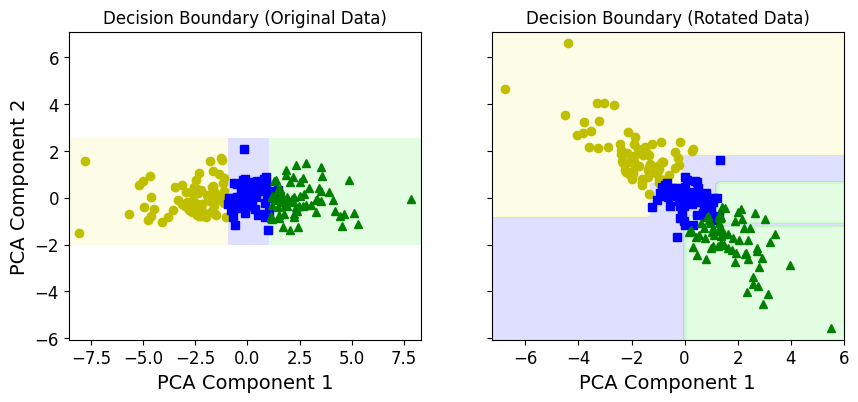

In [60]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)  # Assuming X is your feature matrix
y = y  # Assuming y is your target variable

# Step 2: Define a 45-degree rotation matrix
angle = np.pi / 4  # 45 degrees in radians
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

# Step 3: Apply the rotation to the 2D data
X_rotated = X_2d.dot(rotation_matrix)

# Step 4: Train Decision Tree Classifiers on the original and rotated datasets
tree_clf_original = DecisionTreeClassifier(random_state=42)
tree_clf_original.fit(X_2d, y)

tree_clf_rotated = DecisionTreeClassifier(random_state=42)
tree_clf_rotated.fit(X_rotated, y)

# Step 5: Plot the decision boundaries for both classifiers
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# Plot the decision boundary for the original 2D data
plt.sca(axes[0])
plot_decision_boundary(tree_clf_original, X_2d, y, axes=[X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5,
                                                        X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5])
plt.title("Decision Boundary (Original Data)")

# Plot the decision boundary for the rotated 2D data
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated, X_rotated, y, axes=[X_rotated[:, 0].min() - 0.5, X_rotated[:, 0].max() + 0.5,
                                                            X_rotated[:, 1].min() - 0.5, X_rotated[:, 1].max() + 0.5])
plt.title("Decision Boundary (Rotated Data)")
plt.ylabel("")

plt.show()

Other parameters that  restrict the shape of the Decision Tree:


*   min_samples_split (the minimum number of sam‐ ples a node must have before it can be split)
*   min_samples_leaf (the minimum num‐ ber of samples a leaf node must have)
*   min_weight_fraction_leaf (same as min_samples_leaf but expressed as a fraction of the total number of weighted instances)
* max_leaf_nodes (maximum number of leaf nodes)
* max_features (maximum number of features that are evaluated for splitting at each node).
**Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model; resulting in a smaller tree & reduced overfitting**
